<a href="https://colab.research.google.com/github/karlmanalo/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

# [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
# Convert df['Date'] to datetime format

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [0]:
# Convert df['Great'] from boolean values to 0/1

df['Great'] = df['Great'].astype(int)

In [0]:
# Performing train/validate/test split. See below comment cell for 
# .cutoff_unreliable.

cutoff_train = pd.to_datetime('2017-01-01')
cutoff_val = pd.to_datetime('2018-01-01')
cutoff_unreliable = pd.to_datetime('2018-09-01')

train = df[ df['Date'] < cutoff_train ]
val = df[ (df['Date'] >= cutoff_train) & (df['Date'] < cutoff_val) ]
test = df[ (df['Date'] >= cutoff_val) & (df['Date'] < cutoff_unreliable) ]

In [11]:
train.shape, val.shape, test.shape

((298, 59), (85, 59), (26, 59))

In [0]:
# One of the reviews from this code cell *was* from 2026. Probably a typo of 
# .2016, but after seeing this, I briefly read the front page of 
# .https://srcole.github.io/100burritos/ and saw that their "last update" was 
# .August 2018. Because of this, any data beyond August 2018 is unreliable and
# .I have chosen to filter it out in the above code cell.

# test.head()

# [ ] Begin with baselines for classification.


In [13]:
# Taking a look at the data

train.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [14]:
train.corr()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso,Great
Yelp,1.000000,0.585133,0.013569,0.109067,NaN,NaN,0.397478,0.065553,0.325606,0.274195,-0.000352,0.078049,0.286679,0.005976,-0.072920,0.189677,0.272944,-0.059679,NaN,0.205121
Google,0.585133,1.000000,-0.001470,0.138669,NaN,NaN,0.160693,0.151752,0.223473,0.326674,-0.094125,0.058849,0.332585,0.154295,-0.054090,0.265229,0.269943,-0.024867,NaN,0.159915
Cost,0.013569,-0.001470,1.000000,0.002414,NaN,NaN,-0.079064,0.403674,0.302008,-0.049891,-0.083887,0.168506,0.185456,-0.076590,-0.106477,0.150133,0.050917,-0.163589,NaN,0.142365
Hunger,0.109067,0.138669,0.002414,1.000000,NaN,NaN,0.118518,-0.158323,-0.073466,0.146126,0.087378,0.081790,0.183629,0.121039,0.094913,0.133990,0.168491,0.012002,NaN,0.158043
Mass (g),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,0.397478,0.160693,-0.079064,0.118518,NaN,NaN,1.000000,-0.067762,0.527826,0.165723,-0.067528,-0.054290,0.109499,-0.038337,0.045785,0.041607,0.071656,0.040159,NaN,0.045870
Circum,0.065553,0.151752,0.403674,-0.158323,NaN,NaN,-0.067762,1.000000,0.806687,0.048642,-0.186784,0.158569,0.124948,-0.028323,-0.029974,0.102384,0.068080,-0.175470,NaN,0.067621
Volume,0.325606,0.223473,0.302008,-0.073466,NaN,NaN,0.527826,0.806687,1.000000,0.135366,-0.195904,0.101055,0.167131,-0.053833,-0.002003,0.097130,0.091221,-0.135104,NaN,0.072906
Tortilla,0.274195,0.326674,-0.049891,0.146126,NaN,NaN,0.165723,0.048642,0.135366,1.000000,0.287502,0.282051,0.375572,0.244356,0.245504,0.280748,0.353218,0.164170,NaN,0.377766


In [15]:
test.corr()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso,Great
Yelp,1.000000,-0.500000,-0.939412,-0.576557,NaN,NaN,NaN,NaN,NaN,-0.802955,0.500000,-0.944911,-0.944911,-0.359211,-0.917663,-0.500000,-0.866025,-1.000000,NaN,-1.000000
Google,-0.500000,1.000000,0.172841,0.995871,NaN,NaN,NaN,NaN,NaN,0.917663,0.500000,0.755929,0.755929,0.987829,0.802955,-0.500000,0.866025,0.500000,NaN,0.500000
Cost,-0.939412,0.172841,1.000000,0.280704,NaN,NaN,0.225989,0.035735,0.208954,0.424800,-0.230305,-0.222235,0.040959,-0.237252,0.174604,0.016214,-0.025179,0.126820,NaN,0.028949
Hunger,-0.576557,0.995871,0.280704,1.000000,NaN,NaN,0.296181,-0.325647,-0.085825,0.610310,0.266759,-0.094256,0.221245,0.101226,0.235677,-0.034309,0.094443,0.219593,NaN,0.211450
Mass (g),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,NaN,NaN,0.225989,0.296181,NaN,NaN,1.000000,-0.160571,0.573914,0.356627,0.390992,-0.042426,-0.128506,-0.167312,0.114910,0.090656,-0.095492,-0.192079,NaN,0.259682
Circum,NaN,NaN,0.035735,-0.325647,NaN,NaN,-0.160571,1.000000,0.712187,0.099108,0.026593,0.328332,0.453083,0.191572,0.114700,0.003739,0.234704,-0.165699,NaN,0.052767
Volume,NaN,NaN,0.208954,-0.085825,NaN,NaN,0.573914,0.712187,1.000000,0.318659,0.281018,0.220728,0.266151,-0.013626,0.128596,0.060181,0.113832,-0.278475,NaN,0.209936
Tortilla,-0.802955,0.917663,0.424800,0.610310,NaN,NaN,0.356627,0.099108,0.318659,1.000000,0.277094,-0.023517,0.233039,0.204103,0.436102,0.109793,0.277786,0.197345,NaN,0.404919


In [16]:
# Defining target, finding majority class. 59.06 % of burritos are not 
# .considered "Great".

target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.590604
1    0.409396
Name: Great, dtype: float64

In [0]:
# Defining majority class of a set, defining y_pred as an array of the mode of 
# .y_train.

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [18]:
# Checking accuracy score of majority class prediction on train set.

from sklearn.metrics import accuracy_score

print(f'The accuracy score of our train set is {accuracy_score(y_train, y_pred)}')

The accuracy score of our train set is 0.5906040268456376


In [19]:
# Checking accuracy score of majority class prediction on val set.

y_val = val[target]
y_pred = [majority_class] * len(y_val)

print(f'The accuracy score of our val set is {accuracy_score(y_val, y_pred)}')

The accuracy score of our val set is 0.5529411764705883


# [ ] Use scikit-learn for logistic regression.


In [0]:
# Importing Logistic Regression, instantiating Logistic Regression

from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()

In [0]:
# Picking features to perform logistic regression

features = ['Fillings', 'Meat:filling', 'Synergy', 'Salsa']

In [0]:
# Defining X_train and X_val

X_train = train[features]
X_val = val[features]

In [0]:
# Imputing missing values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

In [24]:
# Fitting logistic regression model to X_train_imputed

logistic_reg.fit(X_train_imputed, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Applying model to X_val_imputed

y_pred = logistic_reg.predict(X_val_imputed)

# [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [26]:
print(f'Accuracy Score for Validation Set:{accuracy_score(y_val, y_pred)}')

Accuracy Score for Validation Set:0.8588235294117647


# [ ] Get your model's test accuracy. (One time, at the end.)

In [0]:
# Defining X_test, y_test, imputing X_test, defining y_pred

X_test = test[features]
y_test = test[target]
X_test_imputed = imputer.transform(X_test)
y_pred = logistic_reg.predict(X_test_imputed)

In [31]:
# This seems the opposite of good. Small sample size though?

print(f'Accuracy Score for Test Set:{accuracy_score(y_test, y_pred)}')

Accuracy Score for Test Set:0.6153846153846154


## Stretch Goals

- [ ] Make exploratory visualizations.

- [ ] Do one-hot encoding.

In [0]:
features = ['Burrito', 'Fillings', 'Meat:filling', 'Synergy', 'Salsa']

X_train = train[features]
X_val = val[features]

In [0]:
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
scaler = StandardScaler()

In [0]:
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [0]:
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [0]:
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [53]:
logistic_reg_CV = LogisticRegressionCV()
logistic_reg_CV.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [54]:
y_pred = logistic_reg_CV.predict(X_val_scaled)
print(f'Accuracy Score for Validation Set:{accuracy_score(y_val, y_pred)}')

Accuracy Score for Validation Set:0.8235294117647058


- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).

# Done above.

- [ ] Get and plot your coefficients.

Burrito_California     0.129426
Burrito_Carnitas       0.005293
Burrito_Asada         -0.025775
Burrito_Other         -0.071250
Burrito_Surf & Turf   -0.084926
Fillings               0.725196
Meat:filling           0.573925
Synergy                0.779348
Salsa                  0.348633
dtype: float64


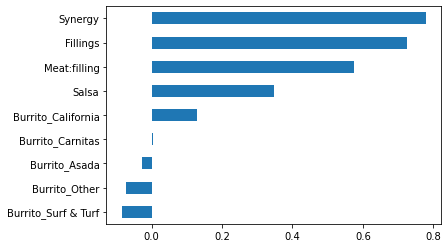

In [56]:
%matplotlib inline
coefficients = pd.Series(logistic_reg_CV.coef_[0], X_train_encoded.columns)
print(coefficients)
coefficients.sort_values().plot.barh();

- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).